---
badges: true
categories:
- cuda
- python
date: '2024-03-16'
title: Benchmark CUDA kernel with Python
image: gpu.jpeg
toc: false
---

In this tutorial, we'll see the impact of block size on the performance of a CUDA kernel. We'll use `subprocess` module in Python standard library to compile and execute a CUDA program which is defined in runtime.

Let's first verify that the device has a NVIDIA GPU and CUDA.

In [6]:
#| code-fold: true
!nvidia-smi

Sat Mar 16 12:09:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0              32W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

We'll use a simple vector addition kernel which will be executed in parallel by many threads in multiple blocks on the GPU. The whole program is defined as a string. We'll replace BLOCKS_SIZE variable in runtime to try different block size values.



In [3]:
TEMPLATE = r"""
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <cuda.h>

__global__ void vector_addition_kernel(float *a, float *b, float *out, int N)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;

    if (i < N)
    {
        out[i] = a[i] + b[i];
    }
}

int main(void)
{

    const int N = 1 << 28; // Number of elements in arrays
    float *a, *b, *out;
    float *a_d, *b_d, *out_d;

    int BLOCK_SIZE = 1;
    int NUM_BLOCKS = N / BLOCK_SIZE + (N % BLOCK_SIZE == 0 ? 0 : 1);

    dim3 BLOCK_SIZE_DIM3 = dim3(BLOCK_SIZE, 1, 1);
    dim3 NUM_BLOCKS_DIM3 = dim3(NUM_BLOCKS, 1, 1);

    size_t size = N * sizeof(float);

    // Allocate memory
    a = (float *)malloc(size);
    b = (float *)malloc(size);
    out = (float *)malloc(size);

    cudaMalloc(&a_d, size);
    cudaMalloc(&b_d, size);
    cudaMalloc(&out_d, size);

    // Fill arrays with random values
    for (int i = 0; i < N; i++)
    {
        a[i] = rand() / (float)RAND_MAX;
        b[i] = rand() / (float)RAND_MAX;
    }

    cudaMemcpy(a_d, a, size, cudaMemcpyHostToDevice);
    cudaMemcpy(b_d, b, size, cudaMemcpyHostToDevice);

    clock_t start = clock();

    vector_addition_kernel<<<NUM_BLOCKS_DIM3, BLOCK_SIZE_DIM3>>>(a_d, b_d, out_d, N);
    cudaDeviceSynchronize();

    clock_t end = clock();
    double elapsed_time_ms = 1000 * (double)(end - start) / CLOCKS_PER_SEC;
    printf("Elapsed time: %f ms\n", N, elapsed_time_ms);

    cudaMemcpy(out, out_d, size, cudaMemcpyDeviceToHost);

    // cleanup the host memory
    free(a);
    free(b);
    free(out);

    cudaFree(a_d);
    cudaFree(b_d);
    cudaFree(out_d);
}
"""

In [4]:
import subprocess
import re
import matplotlib.pyplot as plt

def run_cuda_code(code: str):
    # Save the generated CUDA code to a file
    with open("program.cu", "w") as f:
        f.write(code)

    # Compile the CUDA code
    subprocess.run(["nvcc", "-o", "program", "program.cu"], check=True)

    # Run the compiled executable and capture its output
    result = subprocess.run(["./program"], capture_output=True, text=True)

    # Extract the execution time from the output
    execution_time = float(re.search(r"Elapsed time: (\d+\.\d+) ms", result.stdout).group(1))
    return execution_time

block_sizes = [2**i for i in range(11)]
execution_times = []

for block_size in block_sizes:
    code = TEMPLATE.replace("int BLOCK_SIZE = 1;", f"int BLOCK_SIZE = {block_size};")
    execution_time = run_cuda_code(code)
    execution_times.append(execution_time)

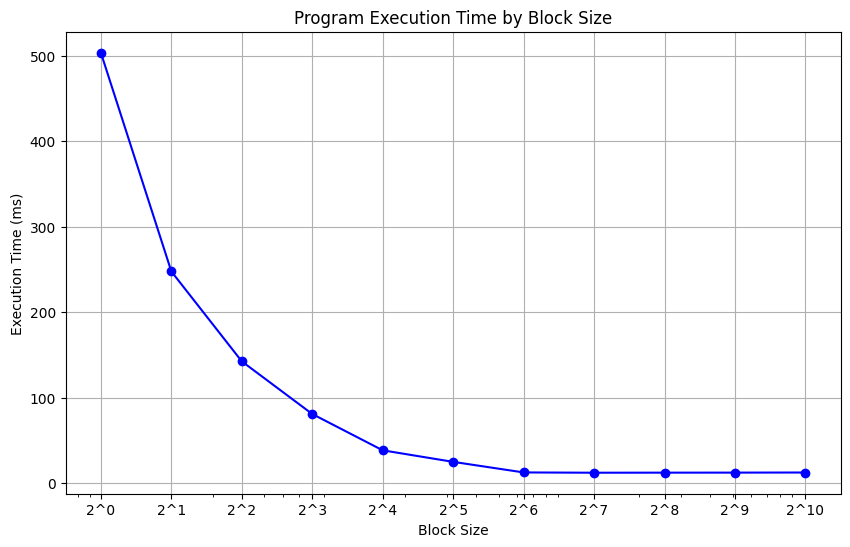

In [5]:
import math

plt.figure(figsize=(10, 6))
plt.plot(block_sizes, execution_times, marker='o', linestyle='-', color='b')
plt.xscale("log")
plt.title('Program Execution Time by Block Size')
plt.xlabel('Block Size')
plt.ylabel('Execution Time (ms)')
plt.xticks(block_sizes, labels=[f"2^{int(math.log(block_size, 2))}" for block_size in block_sizes])
plt.grid(True)
plt.show()

The figure above shows a decrease in execution time with bigger block size until it hits 64 threads. Beyond this point, there's a noticeable plateau, signifying no further gains in speed.